In [78]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet
from sklearn.metrics import  r2_score
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb
import xgboost as xgb
from subprocess import check_output
print(check_output(['ls','input']).decode('utf8'))

sample_submission.csv
test.csv
train.csv



In [79]:
train = pd.read_csv('input/train.csv', parse_dates=['start_date','creation_date','sell_date'])
test = pd.read_csv('input/test.csv', parse_dates=['start_date','creation_date','sell_date'])

print('Train data size: {} Test data size: {}'.format(train.shape, test.shape))

Train data size: (9366, 18) Test data size: (4801, 17)


In [80]:
train['desk_id'].fillna('DSK00000099', inplace=True)
test['desk_id'].fillna('DSK00000099', inplace=True)

train['desk_id']=train.desk_id.apply(lambda x : x[-4:]).astype(np.int16)
test['desk_id']=test.desk_id.apply(lambda x : x[-4:]).astype(np.int16)

In [81]:
le = LabelEncoder()
le.fit(train['office_id'])
train['office_id'] = le.transform(train['office_id'])
test['office_id'] = le.transform(test['office_id'])

In [82]:
le.fit(train['pf_category'])
train['pf_category'] = le.transform(train['pf_category'])
test['pf_category'] = le.transform(test['pf_category'])

In [83]:
train['start_creation'] = (train.start_date - train.creation_date).dt.days
test['start_creation'] = (test.start_date - test.creation_date).dt.days

In [84]:
train['start_sell'] = (train.start_date - train.sell_date).dt.days
test['start_sell'] = (test.start_date - test.sell_date).dt.days

In [85]:
train['creation_sell'] = (train.creation_date - train.sell_date).dt.days
test['creation_sell'] = (test.creation_date - test.sell_date).dt.days

In [86]:
train['curr_to_eur'] = train['currency'].apply(lambda x : 1.18 if x=='USD' else 1.17  if x=='CHF'
                                               else 133.28 if x=='JPY'  else 1)
test['curr_to_eur'] = test['currency'].apply(lambda x : 1.18 if x=='USD' else 1.17  if x=='CHF' 
                                                else 133.28 if x=='JPY'  else 1)

In [87]:
train['sold'].fillna(68552000.0, inplace= True)
train['bought'].fillna(68427270.0, inplace= True)

In [88]:
train['log_sold'] = np.log(train.sold.values)
test['log_sold'] = np.log(test.sold.values)

train['log_bought'] = np.log(train.bought.values)
test['log_bought'] = np.log(test.bought.values)

In [89]:
train['sold_in_eur'] = train['sold']*train['curr_to_eur']
test['sold_in_eur'] = test['sold']*test['curr_to_eur']

train['bought_in_eur'] = train['bought']*train['curr_to_eur']
test['bought_in_eur'] = test['bought']*test['curr_to_eur']

In [90]:
train['dff_sold_bought'] = (train.sold - train.bought)
test['dff_sold_bought'] = (test.sold - test.bought)

#train['log_dff_sold_bought'] = np.log1p(np.abs(train.sold - train.bought))
#test['log_dff_sold_bought'] = np.log1p(np.abs(test.sold - test.bought))

In [91]:
train['gain_loss'] = train.dff_sold_bought * train.euribor_rate *train['curr_to_eur']*train['start_sell']/30
test['gain_loss'] = test.dff_sold_bought * test.euribor_rate *test['curr_to_eur']*test['start_sell']/30

In [92]:
train.drop(['start_date','creation_date', 'sell_date'], inplace=True, axis=1)
test.drop(['start_date','creation_date', 'sell_date'], inplace=True, axis=1)

In [93]:
le.fit(train['country_code'])
train['country_code'] = le.transform(train['country_code'])
test['country_code'] = le.transform(test['country_code'])

In [94]:
le.fit(train['currency'])
train['currency'] = le.transform(train['currency'])
test['currency'] = le.transform(test['currency'])

In [95]:
train['libor_rate'].fillna(0.0, inplace= True)
test['libor_rate'].fillna(0.0, inplace=True)

In [96]:
train['sold_libor'] = train['sold']*train['libor_rate']
test['sold_libor'] = test['sold']*test['libor_rate']

train['sold_euribor'] = train['sold']*train['euribor_rate']
test['sold_euribor'] = test['sold']*test['euribor_rate']

In [97]:
train['indicator_code'].fillna(False, inplace= True)
test['indicator_code'].fillna(False, inplace= True)

le.fit(train['indicator_code'])
train['indicator_code'] = le.transform(train['indicator_code'])
test['indicator_code'] = le.transform(test['indicator_code'])

In [98]:
le.fit(train['type'])
train['type'] = le.transform(train['type'])
test['type'] = le.transform(test['type'])

In [99]:
train['hedge_value'].fillna(False, inplace=True)
test['hedge_value'].fillna(False, inplace=True)

train['hedge_value'] = train['hedge_value'].map({False:0, True:1})
test['hedge_value'] = test['hedge_value'].map({False:0, True:1})

In [100]:
train['status'].fillna(False, inplace= True)
test['status'].fillna(False, inplace= True)

train['status'] = train['status'].map({False:0, True:1})
train['status'] = train['status'].map({False:0, True:1})

In [101]:
retn = train['return']
test_portfolio_id = test.portfolio_id.values

#train.drop(['portfolio_id','bought', 'type', 'return'], inplace=True, axis=1)
#test.drop(['portfolio_id','bought', 'type'], inplace=True, axis=1)
train.drop(['portfolio_id',  'return'], inplace=True, axis=1)
test.drop(['portfolio_id'], inplace=True, axis=1)

In [102]:
params = {'learning_rate': 0.04, 
          'num_leaves':70,
          'min_data_in_leaf': 120,
          'max_depth': -1, 
          'colsample_bytree': 0.8,#0.522,
          'boosting': 'gbdt', 
          'application': 'regression', 
          "min_child_samples": 10,
          'metric': 'mae',  
          'verbosity': 0,
          'seed': 32}

In [103]:
lgb_train = lgb.Dataset(train, label=np.log1p(retn))

In [104]:
lgb_cv = lgb.cv(params, lgb_train, num_boost_round=10000, nfold= 5, stratified=False,
                 verbose_eval=100, early_stopping_rounds=40)

[100]	cv_agg's l1: 0.00154651 + 5.66576e-05
[200]	cv_agg's l1: 0.00132841 + 7.0178e-05
[300]	cv_agg's l1: 0.00124895 + 5.8673e-05
[400]	cv_agg's l1: 0.00121167 + 5.00522e-05
[500]	cv_agg's l1: 0.00119477 + 4.76303e-05
[600]	cv_agg's l1: 0.00119077 + 4.18733e-05


In [105]:
nround = lgb_cv['l1-mean'].index(np.min(lgb_cv['l1-mean'])) #mae
#nround = lgb_cv['rmse-mean'].index(np.min(lgb_cv['rmse-mean'])) #rmse
print(nround)

589


In [106]:
model = lgb.train(params, lgb_train, num_boost_round=nround)

In [107]:
r2_score(retn, np.expm1(model.predict(train)))

0.86251178309754584

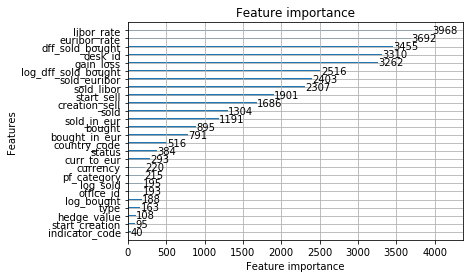

In [108]:
lgb.plot_importance(model)

In [109]:
pred = model.predict(test)

In [110]:
sub = pd.DataFrame({'portfolio_id':test_portfolio_id, 'return':np.expm1(pred)})
sub.head(5)

,portfolio_id,return
0,PF00001001,0.028597
1,PF00001004,0.036310
2,PF00001009,0.023616
3,PF00001013,0.024603
4,PF00001014,0.024796


In [111]:
sub.to_csv('lgb_v4.csv', index=False)